In [1]:
!jupyter nbconvert --to script perform_linear_test.ipynb

[NbConvertApp] Converting notebook perform_linear_test.ipynb to script
[NbConvertApp] Writing 7472 bytes to perform_linear_test.py


In [2]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd
import scipy.stats as stats
from random import shuffle
from multiprocessing import Pool,Array
import sys
import json
import seaborn as sns
from matplotlib import pyplot as plt
proc=15
number_lines=50000

In [3]:
def bin_variable(var1):   # bin with normalization
    
    var1=np.array(var1).astype(np.float)
    
    if abs(np.std(var1))>0.01:
        var1 = (var1 - np.mean(var1))/np.std(var1)
    else:
        var1 = (var1 - np.mean(var1))
    val1 = np.digitize(var1, np.histogram(var1, bins='fd')[1])
    #print(type(val1))
    #print((val1).shape())
    return val1

def p_val_mi(x,y):
    count=0.0
    iterations=10000
    score=metrics.adjusted_mutual_info_score(x,y)
    for i in range(iterations):
        shuffle(x)
        shuffle(y)
        if metrics.adjusted_mutual_info_score(x,y)>=score:
            count+=1.0
    return count/iterations
        
pearsonc=lambda x,y : stats.pearsonr(np.array(x),np.array(y))[0]
p_val_test1=lambda x,y :stats.pearsonr(np.array(x),np.array(y))[1]

ajd_mi_bin=lambda x,y : metrics.adjusted_mutual_info_score(bin_variable(x),bin_variable(y))
p_val_test2= lambda x,y : p_val_mi(bin_variable(x),bin_variable(y))

In [7]:
## Evaluating p-distribution for p-value computation
num_samples_estimation=100000
sig_to_noise_rate=[j*0.05 for j in range(21)] #0, 0.05 ,...,0.95, 1
sig_to_noise_rate[0]=0.0001
num_points=[k*10 for k in range(1,16)]#10,20,30,...150

In [24]:
values_pear=[]
values_MI=[]
# Pearson & MI
for idx_k,k in zip(range(len(num_points)),num_points):
    print('Number of points : '+str(k))
    values_pear.append([])
    values_MI.append([]) 
    for i in range(num_samples_estimation):
        #print(i),
        x = np.random.normal(0,1,k)
        y = np.random.normal(0,1,k)
        values_pear[idx_k].append(pearsonc(x,y))
        values_MI[idx_k].append(ajd_mi_bin(x,y))
        
    with open('Pearson_samples_'+str(k)+'temp_H0.txt','wb') as outfile:
        json.dump(values_pear[idx_k],outfile)
        
    with open('Adj_MI_bin_samples_'+str(k)+'temp_H0.txt','wb') as outfile:
        json.dump(values_MI[idx_k],outfile)

 Number of points : 10
Number of points : 20
Number of points : 30
Number of points : 40
Number of points : 50
Number of points : 60
Number of points : 70
Number of points : 80
Number of points : 90
Number of points : 100
Number of points : 110
Number of points : 120
Number of points : 130
Number of points : 140
Number of points : 150


In [26]:
#Save data generated
for i in range(len(values_pear)):
    values_pear[i]=list(np.sort(values_pear[i],kind='mergesort'))
    values_MI[i]=list(np.sort(values_MI[i],kind='mergesort'))
with open('Pearson_samples_H0.txt','wb') as outfile:
    json.dump(values_pear,outfile)
        
with open('Adj_MI_bin_samples_H0.txt','wb') as outfile:
    json.dump(values_MI,outfile)

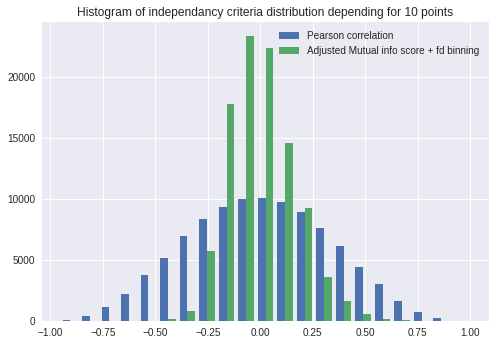

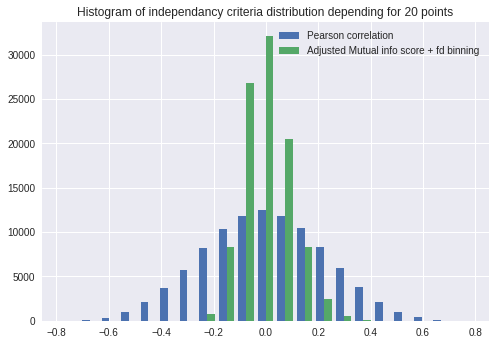

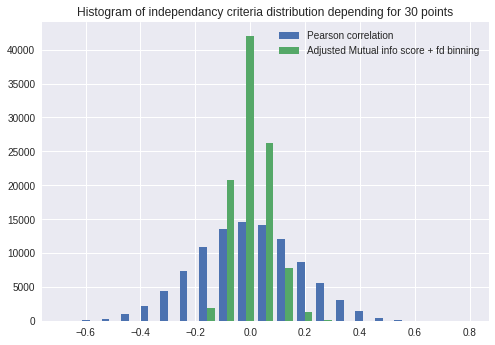

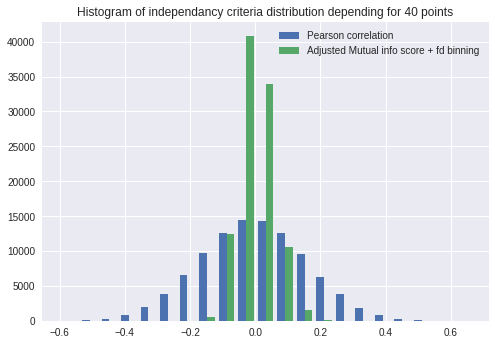

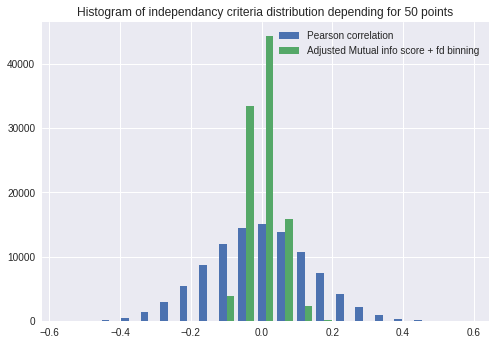

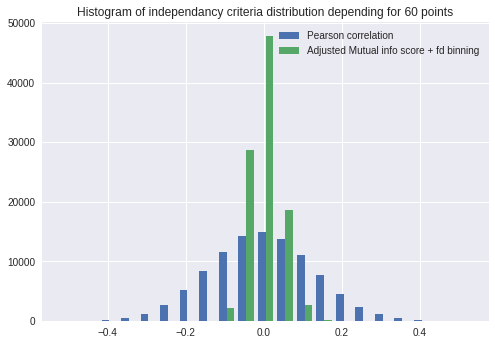

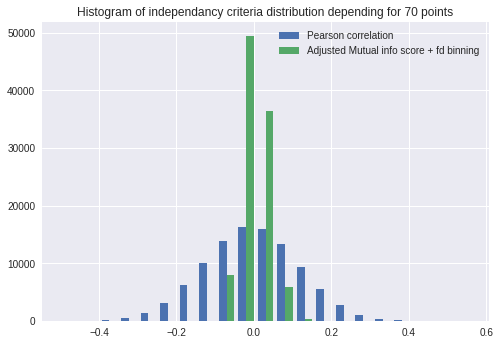

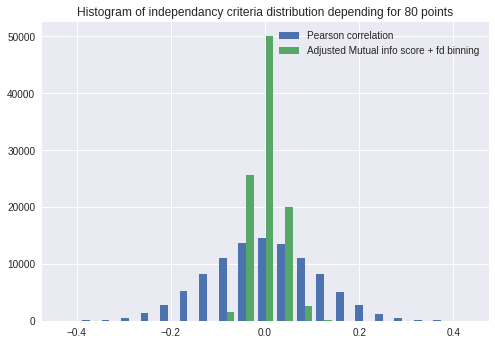

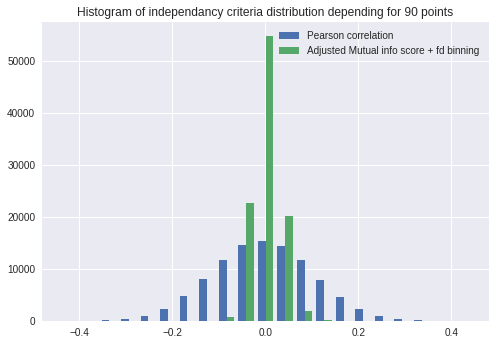

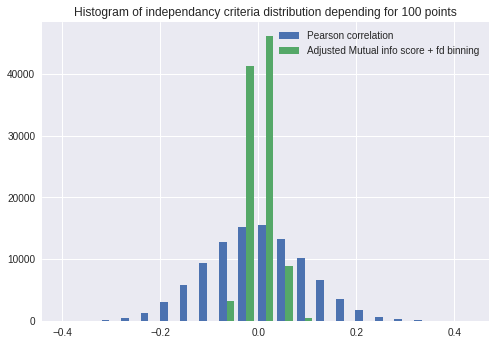

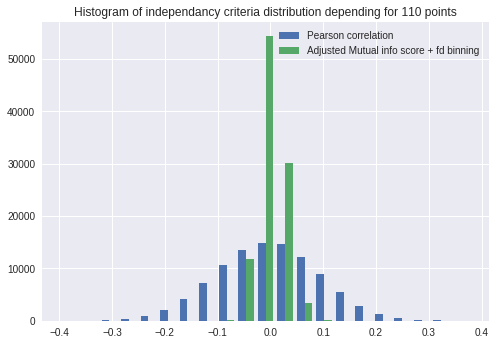

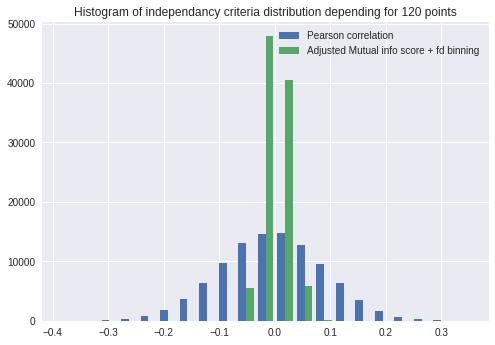

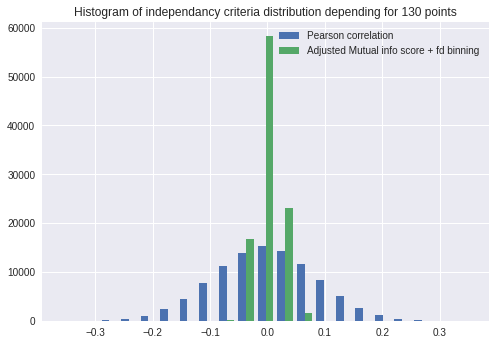

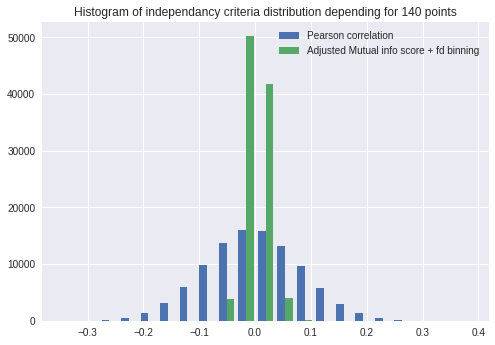

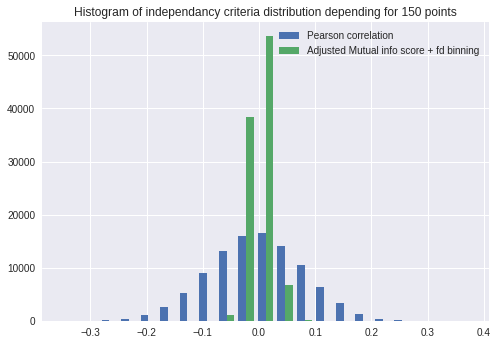

In [11]:
# Analyse density curves?
try:
    values_pear
except NameError:
    with open('Pearson_samples_H0.txt','rb') as input1:
        values_pear=json.load(input1)
    with open('Adj_MI_bin_samples_H0.txt','rb') as input2:
        values_MI=json.load(input2)
for i,nb_pts in zip(range(len(num_points)),num_points): 
    data = np.vstack([values_pear[i],values_MI[i]]).T
    plt.hist(data,bins=21,label=['Pearson correlation','Adjusted Mutual info score + fd binning'])
    plt.title('Histogram of independancy criteria distribution depending for '+str(nb_pts) +' points')
    plt.legend(loc='upper right')
    plt.savefig('figures/histo_distrib_'+str(nb_pts)+'_pts.png')
    plt.show()


In [9]:
# Computation of pear & MI on linear data

num_samples_experiment=1000
result_pear=[]
pval_pear=[]
result_MI=[]
pval_MI=[]

for idx_j,j in zip(range(len(sig_to_noise_rate)),sig_to_noise_rate):
    result_pear.append([])
    print('-Sig/Noise : '+str(j))
    #result_anapear.append([])
    result_MI.append([]) 
    pval_pear.append([])
    pval_MI.append([])
    for idx_k,k in zip(range(len(num_points)),num_points):
        print('--Number of points : '+str(k))
        result_pear[idx_j].append([])
        #result_anapear[idx_j].append([])
        result_MI[idx_j].append([]) 
        pval_pear[idx_j].append([])
        pval_MI[idx_j].append([])
        
        
        for i in range(num_samples_experiment):
            #generate the mecanism
            #print(j),
            #print(k)
            noise=np.random.normal(0,j,k)
            x=np.random.normal(0,1,k)
            y=[sum(s) for s in zip(x, noise)]
            #print(x)
            #print(y)
            pear=pearsonc(x,y)
            MI_score=ajd_mi_bin(x,y)
            result_pear[idx_j][idx_k].append(pear)
            result_MI[idx_j][idx_k].append(MI_score)
            p_rank_MI=float(len(values_pear[idx_k])-1)
            p_rank_pear=float(len(values_pear[idx_k])-1)
            
            while values_pear[idx_k][int(p_rank_pear)]>pear and p_rank_pear>0:
                p_rank_pear-=1.0
            while values_MI[idx_k][int(p_rank_MI)]>pear and p_rank_MI>0:
                p_rank_MI-=1.0
            
            pval_pear[idx_j][idx_k].append((len(values_pear[idx_k])-p_rank_pear)
                                           /len(values_pear[idx_k]))
            pval_MI[idx_j][idx_k].append((len(values_MI[idx_k])-p_rank_MI)
                                           /len(values_MI[idx_k]))

Number of points : 10
Number of points : 20
Number of points : 30
Number of points : 40
Number of points : 50
Number of points : 60
Number of points : 70
Number of points : 80
Number of points : 90
Number of points : 100
Number of points : 110
Number of points : 120
Number of points : 130
Number of points : 140
Number of points : 150
Number of points : 10
Number of points : 20
Number of points : 30
Number of points : 40
Number of points : 50
Number of points : 60
Number of points : 70
Number of points : 80
Number of points : 90
Number of points : 100
Number of points : 110
Number of points : 120
Number of points : 130
Number of points : 140
Number of points : 150
Number of points : 10
Number of points : 20
Number of points : 30
Number of points : 40
Number of points : 50
Number of points : 60
Number of points : 70
Number of points : 80
Number of points : 90
Number of points : 100
Number of points : 110
Number of points : 120
Number of points : 130
Number of points : 140
Number of point

In [15]:
#Save final results
with open('Pearson_p_values.txt','wb') as outfile:
    json.dump(pval_pear,outfile)
        
with open('Adj_MI_p_values.txt','wb') as outfile:
    json.dump(pval_MI,outfile)

with open('Pearson_coeff.txt','wb') as outfile:
    json.dump(result_pear,outfile)
        
with open('Adj_MI_coeff.txt','wb') as outfile:
    json.dump(result_MI,outfile)

In [6]:
#Load final results
try: 
    pval_pear
except NameError:
    with open('Pearson_p_values.txt','r') as outfile:
        pval_pear=json.load(outfile)
        
    with open('Adj_MI_p_values.txt','r') as outfile:
        p_val_MI=json.load(outfile)

    with open('Pearson_coeff.txt','r') as outfile:
        result_pear=json.load(outfile)

    with open('Adj_MI_coeff.txt','r') as outfile:
        result_MI=json.load(outfile)
        
#Plots
all_pts_pval_pear=[np.mean(i) for i in ]


In [13]:
'''def job_compute_scores(row,res_p,p_val_p,res_MI,p_val_MI):
    x=row['X'].split(' ')
    y=row['Y'].split(' ')
  
    sys.stdout.write('row : '+str(row['ID'])
    sys.stdout.flush()
    if x[0]=='':
        x.pop(0)
        y.pop(0)
    x=[float(i) for i in x]
    y=[float(j) for j in y]
    r1=test1(x,y)
    p1=p_val_test1(x,y)
    r2=test2(x,y)
    p2=p_val_test2(x,y)
    
    #Writing results into shared memory
    n_id= int(row['ID'])
    res_p[n_id]=r1
    p_val_p[n_id]=p1
    res_MI[n_id]=r2
    p_val_MI[n_id]=p2'''
                                                                           

"def job_compute_scores(row,res_p,p_val_p,res_MI,p_val_MI):\n    x=row['X'].split(' ')\n    y=row['Y'].split(' ')\n  \n    sys.stdout.write('row : '+str(row['ID'])\n    sys.stdout.flush()\n    if x[0]=='':\n        x.pop(0)\n        y.pop(0)\n    x=[float(i) for i in x]\n    y=[float(j) for j in y]\n    r1=test1(x,y)\n    p1=p_val_test1(x,y)\n    r2=test2(x,y)\n    p2=p_val_test2(x,y)\n    \n    #Writing results into shared memory\n    n_id= int(row['ID'])\n    res_p[n_id]=r1\n    p_val_p[n_id]=p1\n    res_MI[n_id]=r2\n    p_val_MI[n_id]=p2"

In [ ]:
#Load dataset
''''''chunked_data=pd.read_csv('linear_dataset.csv',chunksize=10**4)
data=pd.DataFrame()
for chunk in chunked_data:
    data=pd.concat([data,chunk])'''

In [12]:
#Main computation loop
'''p=Pool(processes=proc)
res_p=Array('d',range(number_lines))
p_val_p=Array('d',range(number_lines))
res_MI=Array('d',range(number_lines))
p_val_MI=Array('d',range(number_lines))
idlist=[]
coeff=[]
noise_sig=[]
nb_pts=[]

for idx,row in data.iterrows():
    p.apply_async(job_compute_scores,(row,res_p,p_val_p,res_MI,p_val_MI))
    idlist.append(row['ID'])
    coeff.append(row['Coeff'])
    nb_pts.append(row['Nb_pts'])
    noise_sig.append(row['Noise/Sig'])
p.close()
p.join()

result=[]
for i in range(len(idlist)):
    result.append([idlist[i],res_p[i],p_val_p[i],res_MI[i],p_val_MI[i],
                   coeff[i],nb_pts[i],noise_sig[i]])

res_df=pd.DataFrame(result,columns=['ID','Pearson_Correlation','Pearson_p-val',
                                    'Mutual_information','MI_p-val',
                                    'Coeff','Nb_pts','Noise/Sig'])
res_df.to_csv('result_linear_test.csv',index=False)
    '''

NameError: name 'data' is not defined